In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings

In [4]:
from multicam.mah import get_mah

# Indicator and merger impact

In [5]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [6]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


## Construct indicator for each scale bin, merger ratio

In [7]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [8]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

## Train MultiCAM on data for cvir

In [10]:
from multicam.models import prepare_datasets, training_suite, tbl_to_arr

In [11]:
rng = np.random.default_rng(seed=42)

In [12]:
# prepare catalog with all a_m
am_names = [f"am_{ii}" for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])

ma_names = [f"ma_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(ma_peak[:, ii], name=ma_names[ii])

In [16]:
# training data specification
params =('cvir', 'x0', 't/|u|', 'c_to_a', 'spin_bullock')
info = {
    "ma": {
        "x": ma_names,
        "y": params
    },
}

# manual as no train/test split
datasets = {
    'ma': {
        'train': (tbl_to_arr(cat, ma_names), tbl_to_arr(cat, params)),
        'test': (tbl_to_arr(cat, ma_names), tbl_to_arr(cat, params)),
    }
} # same train and test dataset
datasets['ma']['train'][0].shape, datasets['ma']['train'][1].shape

In [18]:
data = {
    "multicam_ma": {
        "xy": datasets["ma"]["train"],
        "n_features": 165,
        "n_targets": 5,
        "model": "linear",
        "kwargs": {"use_multicam": True},
    },
}

In [19]:
models = training_suite(data)
mc = models['multicam_ma']

In [21]:
mc.predict(datasets['ma']['test'][0]).shape

(10000, 5)

In [23]:
# get mean cvir and mean predicted cvir for sanity check
cvir_mean = np.mean(cat['cvir'])
cvir_pred_mean = np.mean(mc.predict(datasets['ma']['test'][0])[:,0])
np.abs(cvir_mean - cvir_pred_mean) / np.abs(cvir_mean)# very low error

5.262648795182711e-05

## Get residuals per scale bin and merger ratio (instantaneous)

In [28]:
from tqdm import tqdm

In [40]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is (cvir, x0, t/u, c_to_a, spin_bullock)
summary_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 3))
summary_no_merger = np.zeros((len(Mu), len(scale_bins) - 1, len(params), 3))

# residuals = (mc.predict(x) - y ) / y 

for kk, mu in enumerate(Mu):
    for jj in tqdm(range(len(scale_bins) - 1)):
        mask = inst_mask[kk, :, jj].astype(bool)
        residuals_merger = (mc.predict(x[mask]) - y[mask]) / y[mask]
        residuals_no_merger = (mc.predict(x[~mask]) - y[~mask]) / y[~mask]

        summary_merger[kk, jj, :, 0] = np.median(residuals_merger, axis=0)
        summary_merger[kk, jj, :, 1] = np.percentile(residuals_merger, 25, axis=0)
        summary_merger[kk, jj, :, 2] = np.percentile(residuals_merger, 75, axis=0)

        summary_no_merger[kk, jj, :, 0] = np.median(residuals_no_merger, axis=0)
        summary_no_merger[kk, jj, :, 1] = np.percentile(residuals_no_merger, 25, axis=0)
        summary_no_merger[kk, jj, :, 2] = np.percentile(residuals_no_merger, 75, axis=0)

100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


Text(0.5, 0, 'Scale')

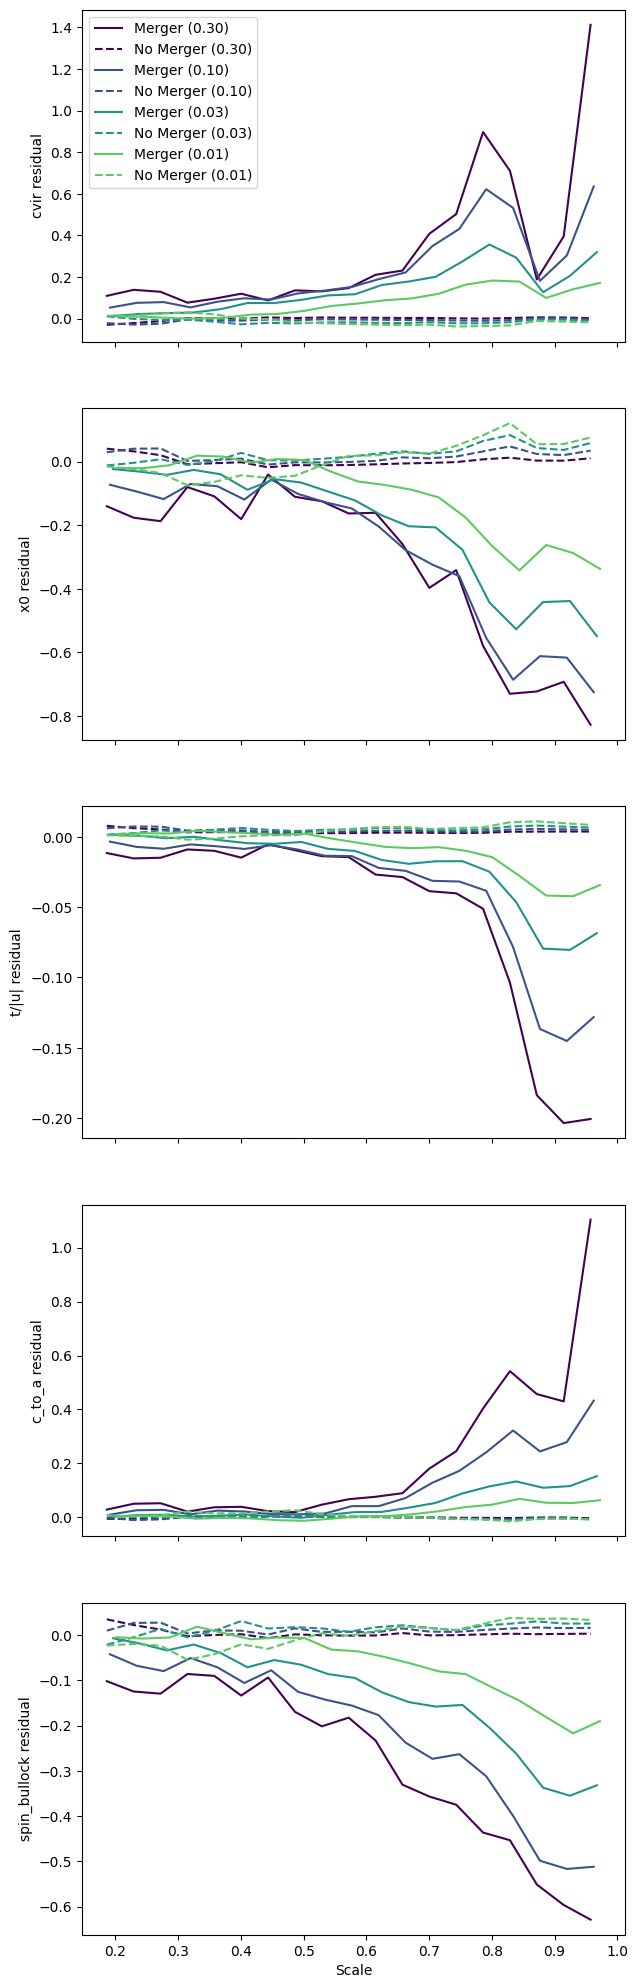

In [42]:
# make plot of median and quartile residuals for each parameter for each merger ratio as a function of scale
# all merger ratios are in the same plot with a color gradient indicating higher merger ratio
fig, axes = plt.subplots(5, 1, figsize=(7, 25), sharex=True)
axes = axes.flatten()
for ii, param in enumerate(params):
    for jj, mu in enumerate(Mu):
        color = plt.cm.viridis(jj / len(Mu))
        lmu = mu / ( 1- mu)
        axes[ii].plot(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, ii, 0], label=f"Merger ({lmu:.2f})", color=color)
        # use error bars instead of fill_between
        # axes[ii].errorbar(scale_bins[:-1]+0.005*jj, summary_merger[jj, :, ii, 0], yerr=[summary_merger[jj, :, ii, 0] - summary_merger[jj, :, ii, 1], summary_merger[jj, :, ii, 2] - summary_merger[jj, :, ii, 0]], color=color)

        # axes[ii].fill_between(scale_bins[:-1], summary_merger[jj, :, ii, 1], summary_merger[jj, :, ii, 2], alpha=0.5, color=color)
        axes[ii].plot(scale_bins[:-1], summary_no_merger[jj, :, ii, 0], label=f"No Merger ({lmu:.2f})", color=color, ls='--')
        # axes[ii].fill_between(scale_bins[:-1], summary_no_merger[jj, :, ii, 1], summary_no_merger[jj, :, ii, 2], alpha=0.5, color=color)
    axes[ii].set_ylabel(f'{param} residual')
axes[0].legend()
axes[-1].set_xlabel('Scale')

Text(0, 0.5, 'Concentration residual')

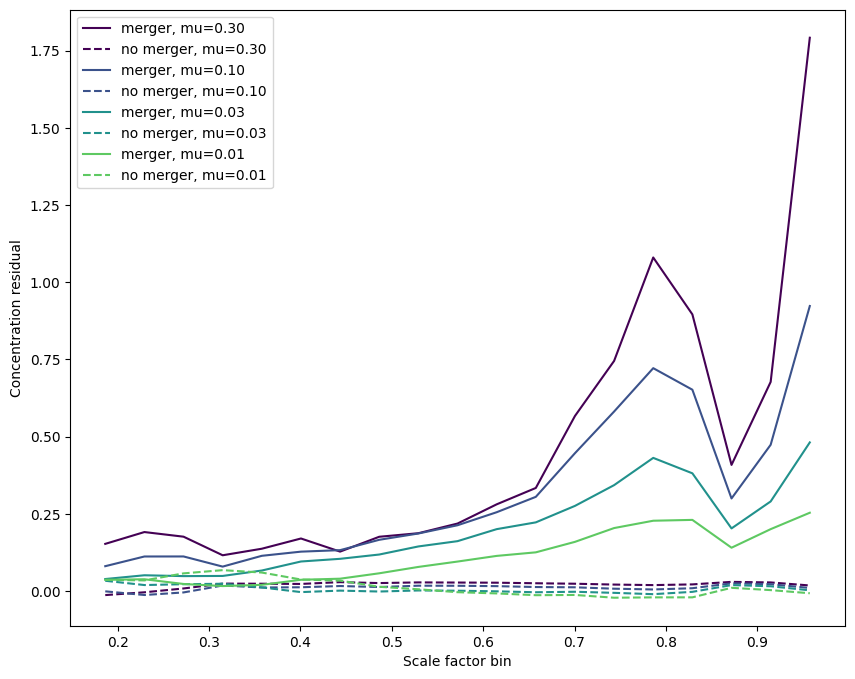

In [153]:
# # plot residual vs scale bin for each mu 
# plt.figure(figsize=(10, 8))
# for kk, mu in enumerate(Mu):
#     color = plt.cm.viridis(kk / len(Mu))
#     lmu = mu / ( 1- mu)
#     plt.plot(scale_bins[:-1], residual_merger[kk], label=f'merger, mu={lmu:.2f}', color=color)
#     plt.plot(scale_bins[:-1], residual_no_merger[kk], label=f'no merger, mu={lmu:.2f}', color=color, linestyle='--')
# plt.legend()
# plt.xlabel('Scale factor bin')
# plt.ylabel('Concentration residual')

## Get residuals per scale bin and merger ratio (present)

In [143]:
# now get residual for each scale bin and for each mu, separating haloes using the indicators
x, y = datasets['ma']['test'] # x is ma, y is cvir
residual_merger_pres = np.zeros((len(Mu), len(scale_bins) - 1))
residual_no_merger_pres = np.zeros((len(Mu), len(scale_bins) - 1))
for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        mask = present_mask[kk, :, jj].astype(bool)

        if xoff[mask].shape[0] == 0:
            residual_merger_pres[kk, jj] = np.nan
        else: 
            residual_merger_pres[kk, jj] = np.mean( (mc.predict(x[mask]) - y[mask]) / y[mask])

        residual_no_merger_pres[kk, jj] = np.mean( (mc.predict(x[~mask]) - y[~mask]) / y[~mask])

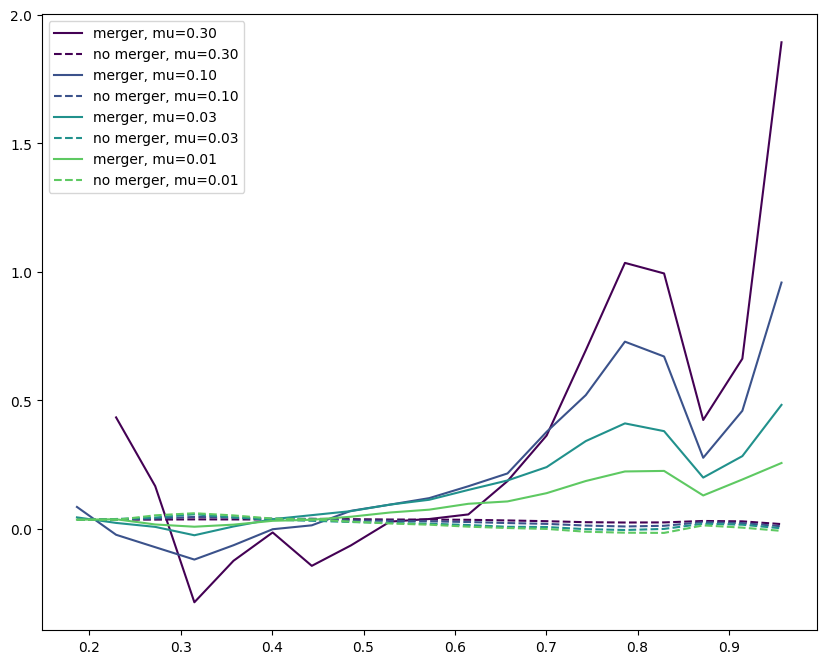

In [154]:
# plot residual vs scale bin for each mu 
plt.figure(figsize=(10, 8))
for kk, mu in enumerate(Mu):
    color = plt.cm.viridis(kk / len(Mu))
    lmu = mu / ( 1- mu)
    plt.plot(scale_bins[:-1], residual_merger_pres[kk], label=f'merger, mu={lmu:.2f}', color=color)
    plt.plot(scale_bins[:-1], residual_no_merger_pres[kk], label=f'no merger, mu={lmu:.2f}', color=color, linestyle='--')
plt.legend()

## Merger factions

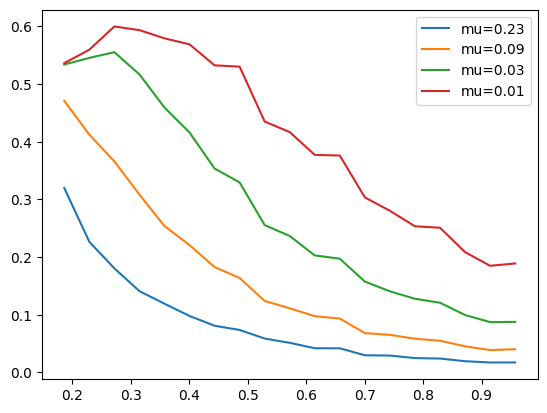

In [16]:
for kk, mu in enumerate(Mu):
    plt.plot(scale_bins[:-1], inst_mask[kk, :].sum(axis=0) / 10000, label=f'mu={mu:.2f}')
plt.legend()